In [17]:
import os
import pickle
import numpy as np
from collections import defaultdict
import datetime
import cedne
from cedne import utils
from tensorly import unfold
from tensorly import concatenate as tl_concatenate
from sklearn.linear_model import Ridge
from tensorly.tenalg import svd_interface
from scipy.spatial.distance import pdist, squareform
import umap
import cvxpy as cp
from numpy.linalg import lstsq, svd
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
from typing import Optional, Tuple, List

In [2]:
today = str(datetime.datetime.now()).split(' ')[0]
outputDir = "Output/" + today + "/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

num_timepoints = 450
conds = ['naive', 'trained']

In [3]:
single_column = 90
double_column = 180
max_height = 170
font_size_big = 7 #pts
font_size_mid = 6
font_size_small = 5
DPI = 600

In [4]:
conds = ['naive', 'trained']
stimuli = ['OP-PA-OP', 'OP-Buffer-OP', 'Buffer-PA-Buffer', 'Buffer-Buffer-Buffer', 'OP-gacA-OP']
promoters = ['ncs-1', 'inx-4', 'glr-1', 'acr-5', 'inx-4+mbr-1', 'flp-3p+flp-7p+nmr-1p+sro-1p', 'odr-2(2b)+odr-2(18)p']
promoter_names = {
    'glr-1': 'inter-motor group',
    'ncs-1': 'sensory-inter group I',
    'inx-4': 'sensory-inter group II',
    'inx-4+mbr-1': 'sensory-inter group III',
    'acr-5': 'sensory-inter-motor group I',
    'odr-2(2b)+odr-2(18)p': 'sensory-inter-motor group II',
    'flp-3p+flp-7p+nmr-1p+sro-1p': 'sensory-inter-motor group III'
    }

In [5]:
def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

In [6]:
picklefile = "../../whole-brain-learning/Output/2025-12-24/worm_tensors_common_neurs.pickle"
with open(picklefile, 'rb') as f:
    all_neurs_set,  worm_tensors = pickle.load(f)

In [7]:
def make_input_matrix_from_label(label: str) -> np.ndarray:
    input_map = {
        "OP":     [1, 0, 0, 0],
        "PA":     [0, 1, 0, 0],
        "gacA":   [0, 0, 1, 0],
        "Buffer": [0, 0, 0, 1],
    }
    T_phase = 150
    parts = label.split("-")  # e.g., ['OP', 'PA', 'OP']
    u = np.zeros((4, T_phase * len(parts)))

    for i, stim in enumerate(parts):
        if stim not in input_map:
            raise ValueError(f"Unrecognized stimulus: {stim}")
        u[:, i*T_phase:(i+1)*T_phase] = np.array(input_map[stim]).reshape(-1, 1)

    return u  # shape: (4, 450)

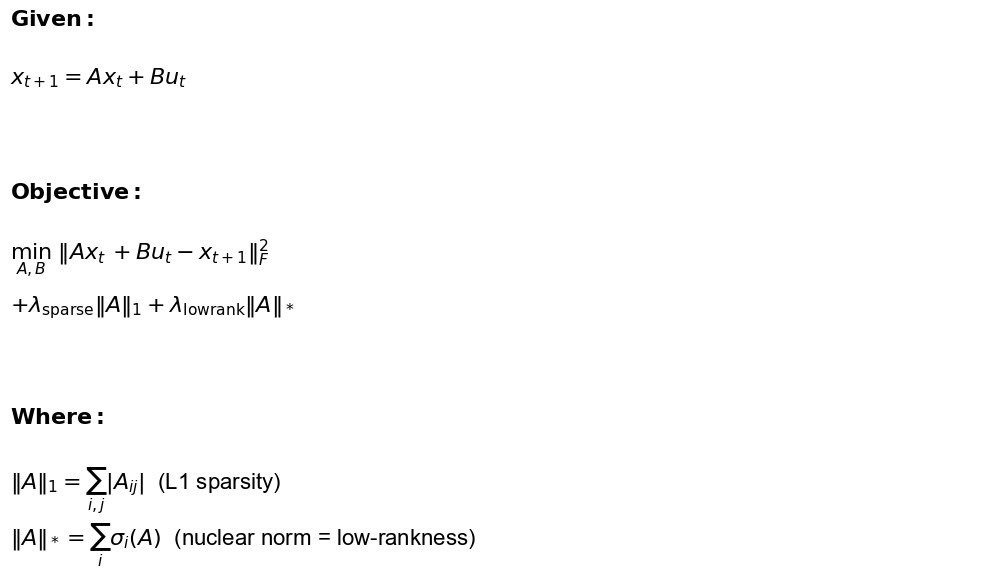

In [8]:
import matplotlib.pyplot as plt

text_lines = [
    r"$\bf{Given:}$",
    r"$x_{t+1} = A x_t + B u_t$",
    "",
    r"$\bf{Objective:}$",
    r"$\min_{A,B} \; \|A x_t + B u_t - x_{t+1}\|_F^2$",
    r"$+ \lambda_{\mathrm{sparse}} \|A\|_1 + \lambda_{\mathrm{lowrank}} \|A\|_*$",
    "",
    r"$\bf{Where:}$",
    r"$\|A\|_1 = \sum_{i,j} |A_{ij}|$  (L1 sparsity)",
    r"$\|A\|_* = \sum_i \sigma_i(A)$  (nuclear norm = low-rankness)",
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

for i, line in enumerate(text_lines):
    ax.text(0, 1 - 0.1 * i, line, fontsize=16, va='top')

plt.tight_layout()
# plt.savefig("fit_sparse_lowrank_equation_mathtext.png", dpi=300)
plt.show()

In [9]:
def compute_fixed_points(A_list, B_list, input_labels=["OP", "PA", "Buffer", "gacA"]):
    """
    Compute x* = (I - A)^-1 B u* for each worm and each input label.

    Parameters
    ----------
    A_list, B_list : list of np.ndarray
        One (A, B) pair per worm. Shapes: A (N, N), B (N, 4)
    input_labels : list of str
        Input names in order matching columns of B (default: ["OP", "PA", "Buffer", "gacA"])

    Returns
    -------
    fixed_points : dict
        fixed_points[worm_idx][label] = x* ∈ ℝ^N
    """
    n_worms = len(A_list)
    fixed_points = {}

    for i in range(n_worms):
        A, B = A_list[i], B_list[i]
        N = A.shape[0]
        I = np.eye(N)

        for j, label in enumerate(input_labels):
            if label not in fixed_points:
                fixed_points[label] = {}
            u = np.zeros((4, 1))
            u[j, 0] = 1  # one-hot input
            try:
                x_star = np.linalg.solve(I - A, B @ u).flatten()
                fixed_points[label][i] = x_star
            except np.linalg.LinAlgError:
                fixed_points[label][i] = None  # singular system

    return fixed_points

In [10]:
## Reconstructing dynamics

def simulate_linear_dynamics(A, B, x0, u, steps):
    """
    Simulate x[t+1] = A x[t] + B u[t] over time.

    Parameters
    ----------
    A : (N, N)
    B : (N, M)
    x0 : (N,) initial state
    u : (M, T) input
    steps : int — number of time steps

    Returns
    -------
    X_sim : (N, T) simulated trajectory
    """
    N = A.shape[0]
    X_sim = np.zeros((N, steps))
    X_sim[:, 0] = x0
    for t in range(1, steps):
        X_sim[:, t] = A @ X_sim[:, t - 1] + B @ u[:, t - 1]
    return X_sim

def plot_reconstruction_comparison(x_true, x_sim_list, labels, neuron_indices=None, worm_idx=0, T_max=150, dt=0.2, transitions = (150,300), figsize=None, save=False):
    """
    Compare true vs reconstructed dynamics for selected neurons.

    Parameters
    ----------
    x_true : (N, T) true data
    x_sim_list : list of (N, T) reconstructions
    labels : list of str, names for each reconstruction
    neuron_indices : list of neuron indices to show (default: 3 random)
    worm_idx : index for title
    T_max : int — number of time steps to display
    """
    N, T = x_true.shape
    if neuron_indices is None:
        neuron_indices = np.random.choice(N, size=3, replace=False)

    if figsize is None:
        figsize = mm_to_inches((single_column, 2.5 * len(neuron_indices)))
    fig, axes = plt.subplots(len(neuron_indices), 1, figsize=figsize, sharex=True, layout='constrained')
    if len(neuron_indices) == 1:
        axes = [axes]
    
    time = np.arange(T_max)*dt
    for ax, i in zip(axes, neuron_indices):
        ax.plot(time, x_true[i, :T_max], label='True', color='black', lw=2, alpha=0.7)
        ax.plot(time, x_sim_list[i, :T_max], label=labels[i], alpha=1, color='magenta', ls='--') 
        ax.set_ylabel(f"{labels[i]}", fontsize=font_size_mid)
        ax.set_ylim((-1,2))
        ax.set_xticks(np.array([0, transitions[0]*dt, transitions[1]*dt, T_max*dt]), labels=[0, f"{int(transitions[0]*dt)}", f"{int(transitions[1]*dt)}", f"{int(T_max*dt)}"])
        ax.tick_params(axis='both', which='major', labelsize=font_size_mid)
        ax.axvline(transitions[0]*dt, color='lightgray', linestyle='--', lw=1)
        ax.axvline(transitions[1]*dt, color='lightgray', linestyle='--', lw=1)
        utils.simpleaxis(ax)
        # print(x_sim_list.shape, len(labels))
    # for x_sim, label in zip(x_sim_list, labels):
        # print(x_sim, label)
        # ax.plot(x_sim[:T_max], label=label, alpha=0.7)
        
    # ax.legend()
    # axes[-1].set_xlabel("Time", fontsize=font_size_mid)
    # fig.suptitle(f"Worm {worm_idx} — True vs Reconstructed Dynamics", fontsize=font_size_big)
    fig.supylabel("Neural Activity", fontsize=font_size_mid)
    fig.supxlabel("Time (s)", fontsize=font_size_mid)
    # plt.tight_layout()
    if not save == False:
        plt.savefig(save, dpi=DPI, transparent=True)
    plt.show()


In [11]:
def compute_r2_per_worm(X_tensor, U, A_list, B_list):
    N, T, W = X_tensor.shape
    T1 = T - 1
    r2_scores = []

    for i in range(W):
        x = X_tensor[:, :, i]        # (N, T)
        A = A_list[i]                # (N, N)
        B = B_list[i]                # (N, 4)

        x_t = x[:, :T1]              # x(t)
        x_tp1_true = x[:, 1:]        # x(t+1)
        u_t = U[:, :T1]              # u(t)

        x_tp1_pred = A @ x_t + B @ u_t  # (N, T-1)

        ss_res = np.sum((x_tp1_true - x_tp1_pred) ** 2, axis=1)
        ss_tot = np.sum((x_tp1_true - x_tp1_true.mean(axis=1, keepdims=True)) ** 2, axis=1)

        r2_neurons = 1 - ss_res / ss_tot
        r2_scores.append(np.mean(r2_neurons))  # average R² across neurons

    return r2_scores  # list of R² per worm

In [12]:
def analyze_stability(A_worms):
    spectral_radius = []
    unstable_count = []
    eigvals = []
    for j in range(len(A_worms)):
        A = A_worms[j]
        eigvals.append(np.linalg.eigvals(A))
        spectral_radius.append(np.max(np.abs(eigvals)))
        unstable_count.append(np.sum(np.abs(eigvals) > 1.0))
    return spectral_radius, unstable_count, eigvals

In [ ]:
def fit_linear_system_tensor(
    X: np.ndarray,
    u: np.ndarray,
    *,
    add_intercept: bool = True,
    ridge_A: float = 1e-3,
    ridge_B: float = 1e-3,
    ridge_d: float = 1e-6,
    enforce_stability: bool = True,
    rho_max: float = 0.995,
    pre_mask: Optional[np.ndarray] = None,
    use_mad_scale: bool = True,
    exog: Optional[np.ndarray] = None,
) -> Tuple[List[np.ndarray], List[np.ndarray], Optional[List[np.ndarray]]]:
    """
    Fit a *first-order affine* system per worm:
        x_{t+1} = A_d x_t + B_d u_t + d    (if add_intercept=True)
        x_{t+1} = A_d x_t + B_d u_t        (otherwise)

    Inputs are assumed already variance-stabilized (you said you log-transformed ΔR/R).
    We still *calibrate per worm* to absorb inter-worm offset/gain without per-trial contrast normalization.

    Parameters
    ----------
    X : np.ndarray
        Neural activity, shape (N, T, W) in a fixed shared basis (e.g., pooled PCs or neurons).
        N = state dimension; T = time; W = worms.
    u : np.ndarray
        Input matrix, shape (M, T), shared across worms (e.g., epoch indicators or continuous drives).
        M = number of input channels.
    add_intercept : bool, default True
        Include constant drive 'd' so absolute equilibria are identifiable.
    ridge_A, ridge_B, ridge_d : float
        Ridge penalties for A_d, B_d, and d. Small >0 stabilizes fits; increase if noisy.
    enforce_stability : bool, default True
        If True, project A_d to have spectral radius < rho_max (discrete-time stability).
    rho_max : float, default 0.995
        Target upper bound on spectral radius after projection.
    pre_mask : Optional[np.ndarray]
        Boolean mask of shape (T,) marking *pre* segments across all trials (per worm).
        Used for per-worm affine calibration (offset/scale). If None, calibration is skipped.
    use_mad_scale : bool, default True
        If True, scale by robust MAD; else by standard deviation during calibration.
    exog : Optional[np.ndarray]
        Optional nuisance regressors (e.g., bleaching/motion), shape (K, T, W).
        Regressed out before fitting A_d/B_d to avoid confounds.

    Returns
    -------
    A_list : list of (N, N) arrays
        One discrete-time A_d per worm.
    B_list : list of (N, M) arrays
        One B_d per worm.
    d_list : list of (N,) arrays or None
        One intercept per worm if add_intercept=True, else None.

    Notes
    -----
    - We fit in *absolute units* (no per-trial contrast), but absorb inter-worm differences
      via per-worm offset/scale using all *pre* points. This keeps fixed points identifiable.
    - Ridge is implemented by *design augmentation*, preserving closed-form speed/stability.
    - Stability projection is a light safeguard; if it triggers often, increase ridge_A.
    """

    N, T, W = X.shape
    M = u.shape[0]
    T1 = T - 1

    # ---- 0) Basic checks -----------------------------------------------------
    assert u.shape[1] == T, "u must have shape (M, T)"
    if pre_mask is not None:
        assert pre_mask.shape == (T,), "pre_mask must have shape (T,)"

    # We remove exogenous effects (e.g., bleaching/motion) so A/B capture neural dynamics.
    Xc = X.copy()
    if exog is not None:
        K = exog.shape[0]
        assert exog.shape[1] == T and exog.shape[2] == W, "exog shape must be (K, T, W)"
        for w in range(W):
            E = exog[:, :, w].T  # (T, K)
            # Add small ridge to avoid overfitting short T (augmented design)
            if K > 0:
                # Augment E and target to implement ridge ~1e-6
                lam_e = 1e-6
                E_aug = np.vstack([E, np.sqrt(lam_e) * np.eye(K)])
            for n in range(N):
                y = Xc[n, :, w]
                if np.any(np.isnan(y)) or np.any(np.isnan(E)):
                    continue
                if K > 0:
                    y_aug = np.hstack([y, np.zeros(K)])
                    beta, *_ = lstsq(E_aug, y_aug, rcond=None)
                    Xc[n, :, w] = y - E @ beta  # residualize

    if pre_mask is not None:
        pm = pre_mask.astype(bool)
        for w in range(W):
            Xpw = Xc[:, pm, w]  # (N, T_pre)
            a = np.nanmedian(Xpw, axis=1, keepdims=True)  # (N,1)
            if use_mad_scale:
                med = np.nanmedian(Xpw, axis=1, keepdims=True)
                mad = np.nanmedian(np.abs(Xpw - med), axis=1, keepdims=True)
                # Guard against zero MAD (flat pre); fall back to small epsilon
                b = np.where(mad > 0, mad, 1.0)
            else:
                sd = np.nanstd(Xpw, axis=1, keepdims=True, ddof=1)
                b = np.where(sd > 0, sd, 1.0)
            # Apply per-worm, per-neuron affine calibration
            Xc[:, :, w] = (Xc[:, :, w] - a) / b

    A_list: List[np.ndarray] = []
    B_list: List[np.ndarray] = []
    d_list: List[np.ndarray] = [] if add_intercept else None

    X_t_all = Xc[:, :T1, :]          # (N, T-1, W)
    X_tp1_all = Xc[:, 1:, :]         # (N, T-1, W)
    u_t = u[:, :T1]                  # (M, T-1), shared

    for w in range(W):
        X_t = X_t_all[:, :, w]      # (N, T-1)
        X_tp1 = X_tp1_all[:, :, w]  # (N, T-1)

        if add_intercept:
            Z = np.vstack([X_t, u_t, np.ones((1, T1))])  # (N+M+1, T-1)
        else:
            Z = np.vstack([X_t, u_t])                    # (N+M, T-1)

        n_cols = Z.shape[0]
        
        # Construct augmented design rows
        aug_rows = 0
        if ridge_A > 0:
            aug_rows += N
        if ridge_B > 0:
            aug_rows += M
        if add_intercept and ridge_d > 0:
            aug_rows += 1

        if aug_rows > 0:
            # Z_aug: (T-1 + aug_rows) x (n_cols) after transposing for lstsq
            Z_aug = np.zeros((T1 + aug_rows, n_cols), dtype=Z.dtype)
            Z_aug[:T1, :] = Z.T

            # Build ridge rows that penalize parameter blocks independently.
            row = T1
            # Penalize A_d by adding sqrt(ridge_A) * [I_N  0  0] rows
            if ridge_A > 0:
                Z_aug[row:row+N, :N] = np.sqrt(ridge_A) * np.eye(N)
                row += N
            # Penalize B_d by adding sqrt(ridge_B) * [0  I_M  0] rows
            if ridge_B > 0:
                Z_aug[row:row+M, N:N+M] = np.sqrt(ridge_B) * np.eye(M)
                row += M
            # Penalize d by adding sqrt(ridge_d) * [0  0  1] row
            if add_intercept and ridge_d > 0:
                Z_aug[row, -1] = np.sqrt(ridge_d)
                # row += 1  # not used later

            # Y_aug: (T-1 + aug_rows) x N_out (transpose target)
            Y_aug = np.zeros((T1 + aug_rows, N), dtype=Z.dtype)
            Y_aug[:T1, :] = X_tp1.T  # (T-1, N)

            # Solve N independent ridge problems with the same Z_aug
            theta, *_ = lstsq(Z_aug, Y_aug, rcond=None)  # (n_cols, N)
            theta = theta.T  # (N, n_cols)
        else:
            # Plain least squares (no ridge)
            theta, *_ = lstsq(Z.T, X_tp1.T, rcond=None)  # (n_cols, N)
            theta = theta.T

        # Extract parameter blocks
        if add_intercept:
            A_d = theta[:, :N]
            B_d = theta[:, N:N+M]
            d = theta[:, -1]
        else:
            A_d = theta[:, :N]
            B_d = theta[:, N:]
            d = None

        # --- Optional stability projection on A_d ----------------------------
        # Ensures discrete-time stability (spectral radius < rho_max).
        if enforce_stability:
            # Compute spectral radius via SVD upper bound (fast) or eigvals (exact for small N)
            try:
                eigvals = np.linalg.eigvals(A_d)
                rho = np.max(np.abs(eigvals))
            except np.linalg.LinAlgError:
                # Fallback: spectral norm as an upper bound
                _, svals, _ = svd(A_d, full_matrices=False)
                rho = svals[0]

            if rho >= rho_max and rho > 0:
                A_d = (rho_max / (rho + 1e-12)) * A_d  # radial scaling to pull inside unit circle

        A_list.append(A_d)
        B_list.append(B_d)
        if add_intercept:
            d_list.append(d)

    return A_list, B_list, d_list

def distance_reduction_to_buffer(
    A_naive: np.ndarray, B_naive: np.ndarray, d_naive: np.ndarray,
    A_tr: np.ndarray, B_tr: np.ndarray, d_tr: np.ndarray,
    A_buf: np.ndarray, B_buf: np.ndarray, d_buf: np.ndarray,
    u_bar_pa: np.ndarray, u_bar_buf: np.ndarray,
    cov: Optional[np.ndarray] = None
) -> Tuple[float, float]:
    """
    Compute the key statistic for the claim:
        Δd = ||x*_{PA,tr} - x*_{Buffer}|| - ||x*_{PA,naive} - x*_{Buffer}||

    Choices:
    - Supports Mahalanobis distance (if cov provided) to control for scale.
    - Otherwise uses Euclidean distance.

    Returns
    -------
    delta_d : float
        Distance reduction (<0 supports 'PA moves toward Buffer after learning').
    d_ratio : float
        Post/pre distance ratio (<1 supports the same claim).
    """
    xb = compute_fixed_point(A_buf, B_buf, d_buf, u_bar_buf)
    xpn = compute_fixed_point(A_naive, B_naive, d_naive, u_bar_pa)
    xpt = compute_fixed_point(A_tr, B_tr, d_tr, u_bar_pa)

    def dist(a, b):
        if cov is None:
            return float(np.linalg.norm(a - b))
        else:
            # Mahalanobis with pooled covariance
            S = cov
            if np.linalg.cond(S) > 1e8:
                S = S + 1e-6 * np.eye(S.shape[0])
            diff = (a - b)
            return float(np.sqrt(diff.T @ np.linalg.inv(S) @ diff))

    d_pre = dist(xpn, xb)
    d_post = dist(xpt, xb)
    delta_d = d_post - d_pre
    d_ratio = (d_post / d_pre) if d_pre > 0 else np.inf
    return delta_d, d_ratio

import numpy as np
from typing import List, Optional, Tuple, Dict

def compute_r2_per_worm(
    X_tensor: np.ndarray,
    U: np.ndarray,
    A_list: List[np.ndarray],
    B_list: List[np.ndarray],
    d_list: Optional[List[np.ndarray]] = None,
    *,
    eval_mask: Optional[np.ndarray] = None,
    return_per_neuron: bool = False,
) -> Tuple[List[float], Optional[List[np.ndarray]], List[float]]:
    """
    Compute one‑step R² for a first‑order *discrete* affine model per worm:
        x_{t+1} ≈ A_d x_t + B_d u_t (+ d)

    Choices / notes
    ---------------
    - Supports an optional intercept 'd' per worm (absolute units / fixed‑point identifiable).
    - Ignores time points via 'eval_mask' (e.g., to drop discontinuities or bad frames).
    - Returns both the mean R² across neurons (per worm) *and* a pooled R² (across all neurons/time) per worm.
      The pooled metric is often more stable when some neurons have near‑zero variance.

    Parameters
    ----------
    X_tensor : np.ndarray
        Neural state, shape (N, T, W). This should already be in your shared basis (e.g., PCs).
    U : np.ndarray
        Input matrix, shape (M, T), shared across worms.
    A_list : list of (N, N)
        One A_d per worm.
    B_list : list of (N, M)
        One B_d per worm.
    d_list : list of (N,), optional
        One intercept vector per worm. If None, model has no intercept.
    eval_mask : np.ndarray of bool, optional
        Shape (T,), True = keep this time index for evaluation. Applied to pairs (t -> t+1),
        so we actually use eval_mask[:-1] for x_t and eval_mask[1:] for x_{t+1}.
        If None, all contiguous pairs are used.
    return_per_neuron : bool, default False
        If True, also return the per‑neuron R² array for each worm.

    Returns
    -------
    mean_r2_per_worm : list[float]
        Mean of per‑neuron R² for each worm (nan‑mean; neurons with zero variance are ignored).
    r2_per_neuron_list : list[np.ndarray] or None
        If requested, per‑neuron R² arrays of shape (N,) per worm; otherwise None.
    pooled_r2_per_worm : list[float]
        Pooled R² per worm computed on concatenated residuals (all neurons, all evaluated timepoints).
    """
    N, T, W = X_tensor.shape
    M, T_u = U.shape
    assert T_u == T, "U must have shape (M, T)"
    assert len(A_list) == W and len(B_list) == W, "A_list and B_list must have length W"
    if d_list is not None:
        assert len(d_list) == W, "d_list must have length W"

    # Build a mask for valid (t -> t+1) pairs
    if eval_mask is None:
        pair_mask = np.ones(T - 1, dtype=bool)
    else:
        eval_mask = eval_mask.astype(bool)
        assert eval_mask.shape == (T,), "eval_mask must have shape (T,)"
        pair_mask = eval_mask[:-1] & eval_mask[1:]  # keep only pairs fully inside the mask

    mean_r2_per_worm: List[float] = []
    pooled_r2_per_worm: List[float] = []
    r2_per_neuron_list: Optional[List[np.ndarray]] = [] if return_per_neuron else None

    # Helper to compute safe R² per neuron (handles zero variance)
    def r2_along_time(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[np.ndarray, float]:
        """
        y_true, y_pred: (N, T_eff)
        Returns: (per_neuron_R2, pooled_R2)
        """
        # Per‑neuron residual/total sums
        resid = y_true - y_pred
        ss_res = np.sum(resid**2, axis=1)

        # Center per neuron over evaluated time to get total variance
        y_mean = np.mean(y_true, axis=1, keepdims=True)
        ss_tot = np.sum((y_true - y_mean) ** 2, axis=1)

        # Avoid divide‑by‑zero: set R² = nan for neurons with ~zero variance
        with np.errstate(divide="ignore", invalid="ignore"):
            r2_neur = 1.0 - ss_res / ss_tot
            r2_neur = np.where(ss_tot > 0, r2_neur, np.nan)

        # Pooled R² (more stable): based on totals across all neurons/time
        ss_res_pool = float(np.sum(resid**2))
        ss_tot_pool = float(np.sum((y_true - y_mean) ** 2))  # same centering per neuron then sum
        pooled_r2 = np.nan if ss_tot_pool == 0.0 else 1.0 - ss_res_pool / ss_tot_pool

        return r2_neur, pooled_r2

    # Iterate worms
    for w in range(W):
        A = A_list[w]          # (N, N)
        B = B_list[w]          # (N, M)
        d = d_list[w] if d_list is not None else None  # (N,) or None

        x = X_tensor[:, :, w]                # (N, T)
        x_t = x[:, :-1][:, pair_mask]        # (N, T_eff)
        x_tp1_true = x[:, 1:][:, pair_mask]  # (N, T_eff)
        u_t = U[:, :-1][:, pair_mask]        # (M, T_eff)

        x_tp1_pred = A @ x_t + B @ u_t       # (N, T_eff)
        if d is not None:
            # Add intercept as a constant drive (broadcast over time)
            x_tp1_pred = x_tp1_pred + d[:, None]

        # Compute R²
        r2_neur, pooled_r2 = r2_along_time(x_tp1_true, x_tp1_pred)

        # Aggregate per‑worm mean R² across neurons (ignore NaNs from zero‑variance neurons)
        mean_r2 = float(np.nanmean(r2_neur)) if np.any(~np.isnan(r2_neur)) else np.nan
        mean_r2_per_worm.append(mean_r2)
        pooled_r2_per_worm.append(pooled_r2)
        if return_per_neuron:
            r2_per_neuron_list.append(r2_neur)

    return mean_r2_per_worm, (r2_per_neuron_list if return_per_neuron else None), pooled_r2_per_worm

def stationary_input(U: np.ndarray, mask: np.ndarray | None = None) -> np.ndarray:
    """
    Return the stationary input vector u_bar for an epoch.
    - If mask is None: fall back to averaging U over all time (keeps your loop unchanged).
    - If mask is a bool vector (T,), average only those frames.
    """
    if mask is None:
        return U.mean(axis=1)  # (M,)
    mask = np.asarray(mask, dtype=bool)
    assert mask.shape == (U.shape[1],), "mask must be length T to match U=(M,T)"
    if not np.any(mask):
        return np.zeros(U.shape[0], dtype=U.dtype)
    return U[:, mask].mean(axis=1)
CHANNEL_INDEX = {"OP": 0, "PA": 1, "gacA": 2, "Buffer": 3}

def ubar_for(stim: str, M: int) -> np.ndarray:
    """Stationary input vector for a one-hot channel (e.g., 'PA' -> [0,1,0,0])."""
    e = np.zeros(M, dtype=float)
    e[CHANNEL_INDEX[stim]] = 1.0
    return e

def compute_fixed_point(A_d: np.ndarray, B_d: np.ndarray, d: np.ndarray | None, u_bar: np.ndarray) -> np.ndarray:
    """Discrete-time fixed point: x* = (I - A_d)^{-1} (B_d u_bar + d)."""
    N = A_d.shape[0]
    rhs = B_d @ u_bar + (d if d is not None else 0.0)
    Mmat = np.eye(N) - A_d
    if np.linalg.cond(Mmat) > 1e8:
        Mmat = Mmat + 1e-6 * np.eye(N)
    return np.linalg.solve(Mmat, rhs)

def safe_fixed_points_per_worm(A_list, B_list, d_list, u_bar) -> np.ndarray:
    """Return x* per worm as (W, N)."""
    W = len(A_list)
    out = []
    for w in range(W):
        d_w = None if d_list is None else d_list[w]
        out.append(compute_fixed_point(A_list[w], B_list[w], d_w, u_bar))
    return np.stack(out, axis=0)

In [14]:
input_tensors = {gen: {prom:{stim:make_input_matrix_from_label(stim) for stim in worm_tensors[gen][prom]} for prom in worm_tensors[gen]} for gen in worm_tensors}

In [18]:
w = utils.makeWorm()
nn_unfolded = w.networks['Neutral']

neuron_class = {}
for n in nn_unfolded.neurons:
    if n[-1] in ['L', 'R'] and n not in ['RIR', 'ADL', 'AVL', 'OLL', 'ASEL', 'ASER']:
        classname = n[:-1]
        if not classname in neuron_class:
            neuron_class[classname] = []
        neuron_class[classname].append(n)

nn_folded = nn_unfolded.fold_network(neuron_class, exceptions=['ASEL', 'ASER'], self_loops=False, data='clean')

In [19]:
fit_systems = {}
fixed_points = {}
sparsity = 0
lowrank = 100
lambda_conn = 50
lambda_diag = 0
gen_filter = ['N2']#, 'inx-7-mutant', 'inx-7-rescue']
ridge_A = 1e-1
ridge_B = 1e-1
ridge_d = 1e-1

for gen in worm_tensors:
    if gen in gen_filter:
        fixed_points[gen] = {}
        fit_systems[gen] = {}
        for prom in worm_tensors[gen]:
            fixed_points[gen][prom] = {}
            fit_systems[gen][prom] = {}
            for stim in worm_tensors[gen][prom]:
                fixed_points[gen][prom][stim] = {}
                fit_systems[gen][prom][stim] = {}

                # Precompute stationary inputs for this stim/epoch
                U = input_tensors[gen][prom][stim]                 # (M, T)
                mask = None
                if 'epoch_masks' in globals():
                    try:
                        mask = epoch_masks[gen][prom][stim]        # could be dict per cond; handled below
                    except Exception:
                        mask = None

                for cond in worm_tensors[gen][prom][stim]:
                    fixed_points[gen][prom][stim][cond] = {}
                    nn_subnet = nn_folded.subnetwork(all_neurs_set[prom])
                    connectome = utils.nx.adjacency_matrix(nn_subnet, nodelist = [nn_subnet.neurons[n] for n in all_neurs_set[prom]])
                    ns = all_neurs_set[prom]

                    X = worm_tensors[gen][prom][stim][cond]
                    fit_systems[gen][prom][stim][cond] = fit_linear_system_tensor(
                        X,
                        U,
                        add_intercept=False,         # we want absolute equilibria
                        ridge_A=ridge_A, ridge_B=ridge_B, ridge_d=ridge_d,
                        enforce_stability=True, rho_max=0.995,
                        pre_mask=None,              # set to your global pre mask if you want per-worm calibration inside
                        exog=None                   # pass bleaching/motion regressors here if available
                    )
                    A_list, B_list, d_list = fit_systems[gen][prom][stim][cond]

                    # Score one-step R^2 (mean per neuron and pooled) — quick goodness-of-fit check
                    mean_r2_per_worm, r2_per_neuron_list, pooled_r2_per_worm = compute_r2_per_worm(
                        X, U, A_list, B_list, d_list=d_list, eval_mask=None, return_per_neuron=True
                    )
                    print(f"[{gen} | {prom} | {stim} | {cond}]  "
                    f"Mean R^2 (per worm): {np.round(np.asarray(mean_r2_per_worm), 3)}  "
                    f"Pooled R^2 (per worm): {np.round(np.asarray(pooled_r2_per_worm), 3)}")

                    epoch_names = set(stim.split('-'))  # e.g., {'OP','PA'} for 'OP-PA-OP'
                    M_inputs = U.shape[0]

                    for epoch_label in epoch_names:
                        if epoch_label not in CHANNEL_INDEX:
                            continue  # skip unknown labels safely

                        # Stationary input vector for that epoch (one-hot)
                        u_bar = ubar_for(epoch_label, M=M_inputs)  # shape (M,)

                        # Compute x* per worm
                        xstars = safe_fixed_points_per_worm(A_list, B_list, d_list, u_bar)  # (W, N)

                        if epoch_label not in fixed_points[gen][prom][stim][cond]:
                            fixed_points[gen][prom][stim][cond][epoch_label] = {}
                        for w in range(xstars.shape[0]):
                            fixed_points[gen][prom][stim][cond][epoch_label][w] = xstars[w]

                # --- (Optional) distance-to-Buffer comparisons within this stim ---
                # If both Buffer and PA conditions exist under the same (gen,prom,stim), compute Δd per worm.
                avail_conds = list(fixed_points[gen][prom][stim].keys())
                if ("Buffer" in avail_conds) and ("PA_naive" in avail_conds) and ("PA_trained" in avail_conds):
                    # Pull params & u_bar for each relevant condition
                    A_buf, B_buf, d_buf = fit_systems[gen][prom][stim]["Buffer"]
                    A_pn,  B_pn,  d_pn  = fit_systems[gen][prom][stim]["PA_naive"]
                    A_pt,  B_pt,  d_pt  = fit_systems[gen][prom][stim]["PA_trained"]

                    # u_bar per condition (use masks if you have them)
                    m_buf = None; m_pa = None
                    if 'epoch_masks' in globals():
                        m_buf = epoch_masks[gen][prom][stim].get("Buffer", None) if isinstance(mask, dict) else None
                        m_pa  = epoch_masks[gen][prom][stim].get("PA", None)      if isinstance(mask, dict) else None
                    u_bar_buf = stationary_input(U, m_buf)
                    u_bar_pa  = stationary_input(U, m_pa)

                    # Per-worm Δd and ratio
                    Wtmp = len(A_buf)
                    delta_d = np.zeros(Wtmp)
                    ratio   = np.zeros(Wtmp)
                    for w in range(Wtmp):
                        dd, rr = distance_reduction_to_buffer(
                            A_naive=A_pn[w], B_naive=B_pn[w], d_naive=(None if d_pn is None else d_pn[w]),
                            A_tr=A_pt[w],    B_tr=B_pt[w],    d_tr=(None if d_pt is None else d_pt[w]),
                            A_buf=A_buf[w],  B_buf=B_buf[w],  d_buf=(None if d_buf is None else d_buf[w]),
                            u_bar_pa=u_bar_pa, u_bar_buf=u_bar_buf,
                            cov=None  # set to pooled covariance in state space if you want Mahalanobis
                        )
                        delta_d[w] = dd
                        ratio[w]   = rr

                    # Store comparison stats under the stim level
                    fixed_points[gen][prom][stim]["PA_vs_Buffer"] = {
                        "delta_d_per_worm": delta_d,
                        "ratio_per_worm": ratio,
                        "mean_delta_d": float(np.mean(delta_d)),
                        "median_delta_d": float(np.median(delta_d)),
                        "mean_ratio": float(np.mean(ratio[np.isfinite(ratio)]))
                    }
                    print(f"[{gen} | {prom} | {stim}]  Δd mean (PA→Buffer, post-pre): "
                        f"{fixed_points[gen][prom][stim]['PA_vs_Buffer']['mean_delta_d']:+.4f}  "
                        f"ratio mean: {fixed_points[gen][prom][stim]['PA_vs_Buffer']['mean_ratio']:.3f}")

[N2 | ncs-1 | OP-PA-OP | naive]  Mean R^2 (per worm): [0.996 0.994 0.995 0.996 0.987 0.995 0.987 0.997 0.997 0.997 0.991 0.987
 0.994 0.996 0.99  0.997 0.997 0.995 0.992]  Pooled R^2 (per worm): [0.997 0.997 0.998 0.997 0.995 0.999 0.998 0.999 0.999 0.999 0.999 0.998
 0.998 0.998 0.999 0.999 0.998 0.998 0.999]
[N2 | ncs-1 | OP-PA-OP | trained]  Mean R^2 (per worm): [0.991 0.992 0.98  0.988 0.993 0.983 0.994 0.99  0.993 0.988 0.989 0.983
 0.992 0.992 0.993 0.995 0.99  0.994 0.993 0.991]  Pooled R^2 (per worm): [0.996 0.997 0.997 0.997 0.999 0.998 0.997 0.997 0.998 0.998 0.997 0.997
 0.998 0.998 0.998 0.999 0.999 0.999 0.998 0.999]
[N2 | ncs-1 | OP-Buffer-OP | naive]  Mean R^2 (per worm): [0.993 0.995 0.985 0.991 0.977 0.985 0.993 0.99  0.987 0.993 0.991 0.995
 0.988 0.992]  Pooled R^2 (per worm): [0.998 0.998 0.998 0.997 0.994 0.994 0.997 0.995 0.998 0.998 0.997 0.999
 0.997 0.998]
[N2 | ncs-1 | OP-Buffer-OP | trained]  Mean R^2 (per worm): [0.985 0.997 0.993 0.992 0.988 0.992 0.992 0.9

In [20]:
fixed_points

{'N2': {'ncs-1': {'OP-PA-OP': {'naive': {'OP': {0: array([ 0.59403758, -0.05672079,  0.13359363,  0.18482162, -0.23041961,
              0.28054289,  0.45124857, -0.04283295, -0.03495009,  0.13914075,
              0.24901356]),
      1: array([ 0.05630897, -0.01361382,  0.06411867, -0.02860881,  0.00677798,
              0.05667336,  0.18386965, -0.04169539, -0.1492939 , -0.06428841,
             -0.03961451]),
      2: array([ 0.02908798, -0.03874378,  0.23434976, -0.04614006, -0.0283091 ,
              0.08650111,  0.06420092, -0.10638206, -0.12274983, -0.15698516,
             -0.08618702]),
      3: array([ 0.08660279,  0.04295153,  0.47347425, -0.06259504, -0.19028073,
             -0.12258653,  0.21474075, -0.03594384, -0.0933424 ,  0.22194838,
             -0.04529835]),
      4: array([ 2.72485731e-01, -1.64972168e-02,  1.35282941e-01, -2.17473162e-02,
             -1.03633494e-02,  1.09881179e-01,  5.88525329e-02, -9.18621970e-05,
             -5.96465487e-02,  4.57661875e-03

## Change stim filter here to generate the OP50-PA14 results.

In [21]:
promoters = list(fixed_points['N2'].keys())
color_conds = {'naive':'gray', 'trained':'orange'}
marker_stim = {'OP': 'o', 'PA':'v', 'gacA':'v', 'Buffer':'x'}
# stim_filter = ['OP-PA-OP' , 'OP-Buffer-OP', 'OP-gacA-OP'] #first the OP context  'OP-Buffer-OP' 
stim_filter = ['Buffer-PA-Buffer', 'Buffer-Buffer-Buffer']#, 'OP-gacA-OP'] #first the OP context

inp_filter = ['Buffer', 'PA', 'OP', 'gacA']
fp_prom = {}
stims = {}
context = {}
genotype = {}
training = {}
for prom in promoters:
    color = []
    fp_prom[prom] = []
    stims[prom] = []
    context[prom] = []
    genotype[prom] = []
    training[prom] = []
    for gen in fixed_points:
        if gen == 'N2': #Getting rid of the mutants for now
            if prom in fixed_points[gen]:
                for stim in fixed_points[gen][prom]:
                    if stim in stim_filter:
                        for cond in fixed_points[gen][prom][stim]:
                            sens_inp = stim.split('-')[1:]  # Removing the pre-period
                            for inp in sens_inp:
                                if inp in fixed_points[gen][prom][stim][cond]:
                                    for j in fixed_points[gen][prom][stim][cond][inp]:
                                        fp_prom[prom].append(fixed_points[gen][prom][stim][cond][inp][j])
                                        #fp_prom[prom].append(fixed_points[gen][prom][stim][cond][inp][j])
                                        # stim1 = stim.split('-')[0]
                                        # stim2 = stim.split('-')[1]
                                        stims[prom].append(inp)
                                        training[prom].append(cond)
                                        context[prom].append(stim)
                                        genotype[prom].append(gen)

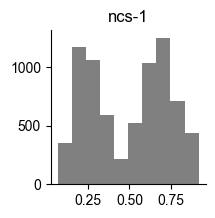

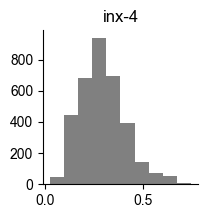

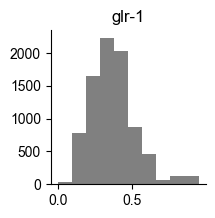

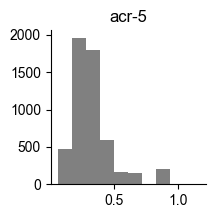

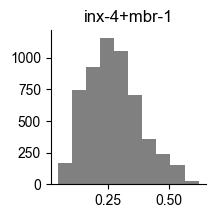

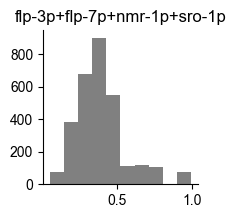

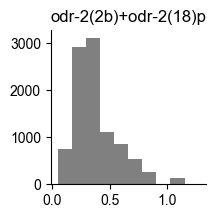

In [22]:
metric = 'euclidean' 
distance_matrix = []
for prom in fp_prom:
    ticks = [] 
    for j in range(len(fp_prom[prom])):
        ticks.append(f'{genotype[prom][j]} {context[prom][j]} {training[prom][j]} {stims[prom][j]}')
    
    # Group the labels by their unique characteristics
    if len(fp_prom[prom]):
        distance_matrix = squareform(pdist(fp_prom[prom], metric=metric))
        lower_tri = np.tril(distance_matrix)
        lower_tri[lower_tri == 0] = np.nan
        fig, ax = plt.subplots(figsize=(2,2))
        bins = np.linspace(0,0.8,100)
        ax.hist(np.log10(1+lower_tri.ravel()), color='gray')
        utils.simpleaxis(ax)
        ax.set_title(prom)
        plt.show()

In [23]:
single_column = 90
double_column = 180
max_height = 170
font_size_big = 7 #pts
font_size_mid = 6
font_size_small = 5
dpi = 600

def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

In [24]:
color_stim = {'OP': '#e4ab24',
              'PA': '#1a9d77',
              'Buffer': "#99c3ee",
              'gacA': "#e142f0"}
color_conds = {'naive': '#888666',
               'trained': '#6b3e98'}

base_markers = ['o','s','^','D','v','P','X','>','<','h']
stim_to_marker = {s: base_markers[i%len(base_markers)] for i, s in enumerate(color_stim.keys())}

single_column = 90
double_column = 180
max_height = 170
font_size_big = 7 #pts
font_size_mid = 6
font_size_small = 5
dpi = 600

def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

In [25]:
# ---- helpers: define canonical order for epoch/training ----
epoch_order = {"Buffer": 0, "PA": 1, "OP": 2, "gacA": 3}   # adjust if you prefer a different order
context_dict = {'OP': ["OP-PA-OP", "OP-Buffer-OP", "OP-gacA-OP"], 'Buffer': ["Buffer-PA-Buffer", "Buffer-Buffer-Buffer"]}
train_order = {"naive": 0, "trained": 1}
n_neighbours = 15


/Users/sahilmoza/miniforge3/envs/cedne-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[ncs-1 | Buffer]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained
  Buffer       0.667    0.469    0.754    1.114        40         41
  PA           1.692    1.174    1.986    2.903        20         21
{('Buffer', 'naive'): array([20, 23, 26, 27, 29, 34, 35, 36, 38, 39, 82, 85, 89, 90, 91, 93, 95,
       97, 98, 99]), ('Buffer', 'trained'): array([ 61,  64,  67,  68,  70,  76,  77,  78,  79, 105, 106, 108, 109,
       110, 111, 113, 114, 115, 119, 120]), ('PA', 'naive'): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), ('PA', 'trained'): array([40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60])}


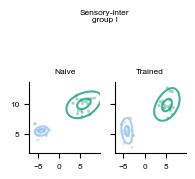

/Users/sahilmoza/miniforge3/envs/cedne-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[inx-4 | Buffer]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained
  Buffer       0.765    0.510    0.878    1.412        21         21
  PA           1.408    0.875    1.539    2.312        21         21
{('Buffer', 'naive'): array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41]), ('Buffer', 'trained'): array([63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
       80, 81, 82, 83]), ('PA', 'naive'): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), ('PA', 'trained'): array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62])}


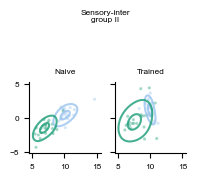

/Users/sahilmoza/miniforge3/envs/cedne-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[glr-1 | Buffer]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained
  Buffer       0.753    0.490    0.836    1.560        39         46
  PA           1.429    1.073    1.767    2.609        19         26
{('Buffer', 'naive'): array([ 19,  20,  21,  23,  25,  26,  32,  34,  36,  37,  93,  94,  96,
        97, 102, 103, 104, 107, 108]), ('Buffer', 'trained'): array([ 64,  65,  72,  73,  74,  77,  83,  86,  88, 111, 112, 115, 116,
       117, 121, 123, 126, 128, 129]), ('PA', 'naive'): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), ('PA', 'trained'): array([38, 39, 40, 41, 42, 43, 45, 47, 49, 51, 55, 56, 57, 58, 59, 60, 61,
       62, 63])}


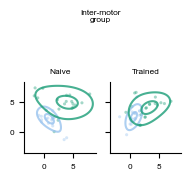

/Users/sahilmoza/miniforge3/envs/cedne-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[acr-5 | Buffer]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained
  Buffer       0.953    0.742    1.106    1.524        35         37
  PA           0.746    0.733    1.305    2.560        15         17
{('Buffer', 'naive'): array([15, 17, 19, 22, 24, 25, 26, 27, 67, 68, 70, 72, 80, 82, 83]), ('Buffer', 'trained'): array([ 47,  48,  51,  54,  60,  88,  89,  90,  92,  95,  96,  98, 100,
       101, 103]), ('PA', 'naive'): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), ('PA', 'trained'): array([30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46])}


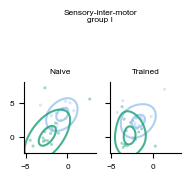

/Users/sahilmoza/miniforge3/envs/cedne-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[inx-4+mbr-1 | Buffer]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained
  Buffer       0.604    0.401    0.715    1.103        35         37
  PA           1.748    1.272    2.022    2.973        15         19
{('Buffer', 'naive'): array([15, 19, 21, 22, 23, 24, 25, 28, 29, 68, 69, 70, 71, 76, 78]), ('Buffer', 'trained'): array([ 49,  50,  53,  57,  58,  66,  88,  89,  90,  91,  92,  95,  97,
       102, 104]), ('PA', 'naive'): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), ('PA', 'trained'): array([30, 32, 33, 34, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48])}


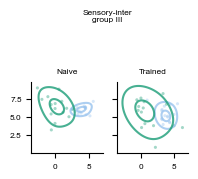

/Users/sahilmoza/miniforge3/envs/cedne-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[flp-3p+flp-7p+nmr-1p+sro-1p | Buffer]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained
  Buffer       1.009    0.693    1.172    2.132        22         17
  PA           1.562    1.089    1.886    3.083        22         17
{('Buffer', 'naive'): array([22, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 42, 43]), ('Buffer', 'trained'): array([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]), ('PA', 'naive'): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 15, 16, 17, 18, 19, 20, 21]), ('PA', 'trained'): array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])}


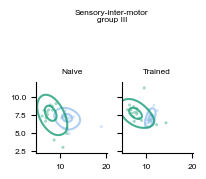

/Users/sahilmoza/miniforge3/envs/cedne-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[odr-2(2b)+odr-2(18)p | Buffer]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained
  Buffer       0.741    0.540    0.824    1.213        45         48
  PA           1.382    1.247    1.912    2.816        23         24
{('Buffer', 'naive'): array([ 23,  24,  25,  27,  29,  30,  32,  33,  39,  40,  42,  43,  44,
        96, 102, 104, 105, 108, 110, 111, 112, 113, 115]), ('Buffer', 'trained'): array([ 75,  76,  79,  80,  81,  83,  87,  88,  89, 116, 120, 121, 122,
       123, 124, 125, 127, 129, 131, 132, 133, 134, 138]), ('PA', 'naive'): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]), ('PA', 'trained'): array([46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69])}


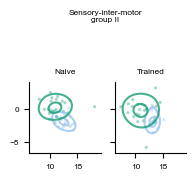

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import seaborn as sns


def centroid_shift(Xa, Xb):
    return float(np.linalg.norm(Xa.mean(0) - Xb.mean(0)))

def bootstrap_ci(Xa, Xb, n_boot=2000, seed=23):
    rng = np.random.default_rng(seed)
    na, nb = len(Xa), len(Xb)
    vals = np.empty(n_boot)
    for i in range(n_boot):
        ia = rng.integers(0, na, na)
        ib = rng.integers(0, nb, nb)
        vals[i] = centroid_shift(Xa[ia], Xb[ib])
    lo, med, hi = np.percentile(vals, [2.5, 50, 97.5])
    return med, (lo, hi)

def fp_stats_by_context(X_fp, stim, train, ctx_mask, stimuli_to_test=('OP', 'PA','Buffer', 'gacA')):
    Xs = X_fp[ctx_mask]
    ss = stim[ctx_mask]
    tt = train[ctx_mask]
    out = []
    for s in stimuli_to_test:
        m_n = (ss == s) & (tt == 'naive')
        m_t = (ss == s) & (tt == 'trained')
        if m_n.sum() == 0 or m_t.sum() == 0:
            continue
        delta = centroid_shift(Xs[m_n], Xs[m_t])
        med, (lo, hi) = bootstrap_ci(Xs[m_n], Xs[m_t])
        out.append((s, delta, lo, med, hi, int(m_n.sum()), int(m_t.sum())))
    return out

rng = np.random.default_rng(23)

def stratified_equal_sample(ctx_mask, stimu, train, per_stim_equal_across_ctx=True):
    # collect indices for each (stim,train) inside this context
    stims_in_ctx = np.unique(stimu[ctx_mask])
    per_stim_n = {}
    bins = {}
    for s in stims_in_ctx:
        na = np.where(ctx_mask & (stimu==s) & (train=='naive'))[0]
        tr = np.where(ctx_mask & (stimu==s) & (train=='trained'))[0]
        n = min(len(na), len(tr))
        if n == 0:
            continue
        per_stim_n[s] = n
        bins[(s,'naive')]   = na
        bins[(s,'trained')] = tr

    if not per_stim_n:
        return {}

    # enforce equal counts across stimuli too
    n_equal = min(per_stim_n.values())  # same n for every stimulus and training

    sampled = {}
    for s in per_stim_n.keys():
        for t in ('naive','trained'):
            idx = bins[(s,t)]
            take = rng.choice(idx, n_equal, replace=False)
            sampled[(s,t)] = np.sort(take)

    return sampled  # dict mapping (stim,train)->indices

from scipy.stats import gaussian_kde

def hdr_levels(x, y, bw_adjust=1.2, gridsize=256, masses=(0.5, 0.8, 0.95)):
    xx = np.linspace(x.min(), x.max(), gridsize)
    yy = np.linspace(y.min(), y.max(), gridsize)
    X, Y = np.meshgrid(xx, yy)
    kde = gaussian_kde(np.c_[x, y].T, bw_method=bw_adjust)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    z = np.sort(Z.ravel())
    cdf = np.cumsum(z) / z.sum()

    def thr(p):
        # smallest HDR containing mass p
        idx = np.searchsorted(cdf, 1 - p, side="left")
        idx = np.clip(idx, 0, len(z) - 1)
        return z[idx]

    lev = np.array([thr(p) for p in masses], float)
    lev = np.unique(lev)
    zmin, zmax = float(Z.min()), float(Z.max())
    eps = (zmax - zmin) * 1e-6
    lev = np.clip(lev, zmin + eps, zmax - eps)
    if len(lev) < 2:
        # fallback: evenly spaced density levels
        lev = np.linspace(zmin + eps, zmax - eps, 3)
    return np.sort(lev)

def to_roman(n):
    romans = [
         ("v", 5), ("iv", 4), ("i", 1)
    ]
    result = ""
    for sym, val in romans:
        while n >= val:
            result += sym
            n -= val
    return result

for col, prom in enumerate(fp_prom):
    if len(fp_prom[prom]) < 2:
        continue

    X_fp  = np.asarray(fp_prom[prom])             # (N, D) fixed-point coords
    stimu = np.asarray(stims[prom])
    cont  = np.asarray(context[prom])
    train = np.asarray(training[prom])

    # sample similar number of points from each stimulus for a given context
    
    X_fp_z = StandardScaler(with_mean=True, with_std=True).fit_transform(X_fp)

    # UMAP on ALL points once
    reducer = umap.UMAP(metric=metric, n_neighbors=15, min_dist=0.05,
                        densmap=True, init='random', random_state=cedne.RANDOM_SEED)
    
    embedding = reducer.fit_transform(X_fp_z)

    xmin, xmax = embedding[:,0].min(), embedding[:,0].max()
    ymin, ymax = embedding[:,1].min(), embedding[:,1].max()
    padx = 0.1 * (xmax - xmin)
    pady = 0.1 * (ymax - ymin)

    for ctx_root, ctx_list in context_dict.items():
        ctx_mask = np.isin(cont, ctx_list)
        if ctx_mask.sum() < 3:
            continue

        # 2a) FP-space statistics (naive vs trained) within this context set
        stats = fp_stats_by_context(X_fp_z, stimu, train, ctx_mask,
                                    stimuli_to_test=np.unique(stimu[ctx_mask]))
        print(f"[{prom} | {ctx_root}]  stimulus  Δcentroid   CI_low   median   CI_high   n_naive  n_trained")
        for s, d, lo, med, hi, nN, nT in stats:
            print(f"  {s:8s}  {d:8.3f}  {lo:7.3f}  {med:7.3f}  {hi:7.3f}    {nN:6d}   {nT:8d}")

        # 2b) UMAP visualization for this context set (same embedding, subset points)
        m = ctx_mask
        stimuli  = np.unique(stimu[m])
        trainings = np.unique(train[m])
        cond2color = {t: color_conds[t] for t in trainings}
        stim2color = {s: color_stim[s] for s in stimuli}
        sampled = stratified_equal_sample(m, stimu, train)
        print(sampled)
        fig, ax = plt.subplots(figsize=mm_to_inches((double_column*2/7., max_height/3)), ncols=2, sharex=True, sharey=True) #layout='constrained'
        # fig, ax = plt.subplots(figsize=mm_to_inches((single_column/1.5, single_column/2.25)), ncols=2, sharex=True, sharey=True)#, layout='constrained')
        for s in stimuli:
            for k,(t,axk) in enumerate([('naive', ax[0]), ('trained', ax[1])]):
                key = (s, t)
                if key not in sampled: 
                    continue
                sel = sampled[key]
                axk.scatter(embedding[sel,0], embedding[sel,1],
                            facecolor=stim2color[s], edgecolor='none',
                            marker='.', alpha=0.4, s=20,  label=f'{s}') #
                # levels may be density thresholds or your HDR levels; either works now
                sns.kdeplot(x=embedding[sel,0], y=embedding[sel,1], ax=axk,
                            # levels=[0.3,3,0.6,0.99], 
                            levels = [0.5, 0.9],
                            bw_adjust=1.8, alpha=0.8,
                            thresh=0.1, fill=False, extend='max', color=stim2color[s], common_norm=False, gridsize=256, cut=3)

        for a in np.ravel(ax):
            a.set_box_aspect(1)                    # fixed square axes box
            # a.set_aspect('equal', adjustable='box')
            a.set_xlim(xmin - padx, xmax + padx)
            a.set_ylim(ymin - pady, ymax + pady)
            utils.simpleaxis(a)
            a.tick_params(axis='both', which='major', labelsize=font_size_mid)
        ax[0].set_title('Naive', fontsize=font_size_mid); ax[1].set_title('Trained', fontsize=font_size_mid )
        prom_lab = '\ng'.join(promoter_names[prom].split(' g'))
        prom_lab = prom_lab[0].upper() + prom_lab[1:]
        fig.suptitle(f'{prom_lab}', fontsize=font_size_mid)
        # after all scatter calls
        handles, labels = [], []
        for a in np.ravel(ax):
            h, l = a.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
        # remove duplicates while keeping order
        seen = set()
        uniq = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]
        plt.show()

## Extended Fig. 10d

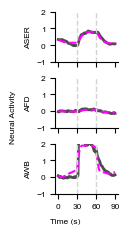

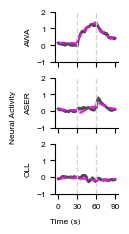

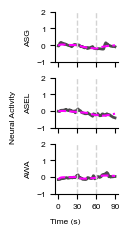

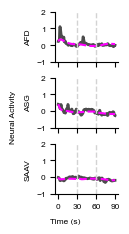

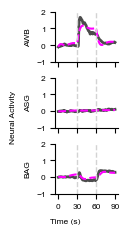

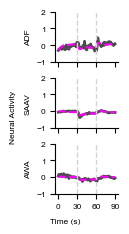

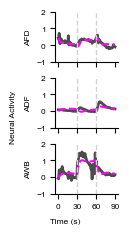

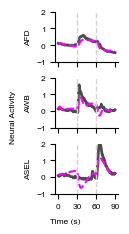

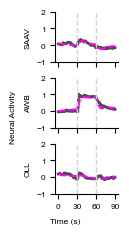

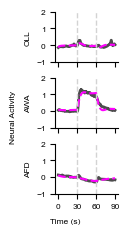

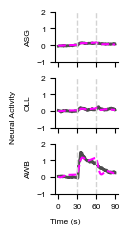

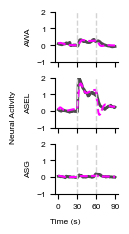

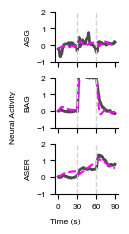

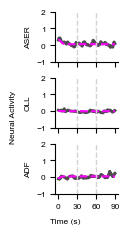

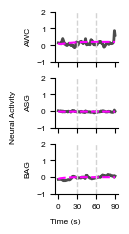

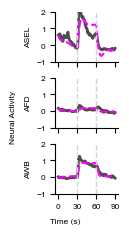

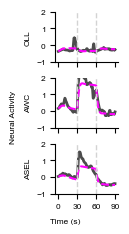

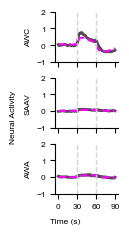

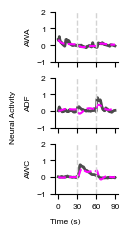

In [125]:
tsteps = 450
for gen in fit_systems:
    for prom in fit_systems[gen]:
        if prom == 'ncs-1':
            for stim in fit_systems[gen][prom]:
                for cond in fit_systems[gen][prom][stim]:
                    alist, blist, dlist = fit_systems[gen][prom][stim][cond]
                    for j in range(worm_tensors['N2'][prom][stim][cond].shape[2]):
                        if j % 10 != 0:
                            continue
                        x = worm_tensors[gen][prom][stim][cond][:,:,j] 
                        x0 = worm_tensors[gen][prom][stim][cond][:,0,j]
                        labels = list(all_neurs_set[prom])
                        u = input_tensors[gen][prom][stim]
                        A = np.array(alist[j])
                        B = np.array(blist[j])
                        # D = np.array(dlist[j])
                        x_sim = simulate_linear_dynamics(A,B, x0, u, tsteps)
                        figsize = mm_to_inches((single_column/3, max_height/3))
                        save = f"figures/reconstructions/{gen}_{prom}_{stim}_{cond}_worm{j}_reconstruction.svg"
                        plot_reconstruction_comparison(x, x_sim, labels=labels, neuron_indices=None, worm_idx=j, dt=0.2, T_max=450, figsize=figsize, save=save)



## Extended Fig. 10e

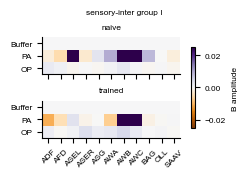

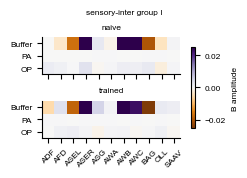

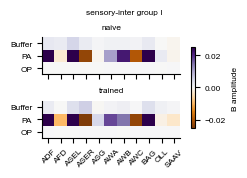

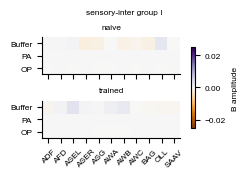

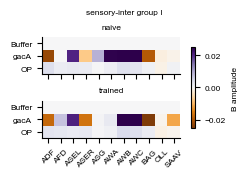

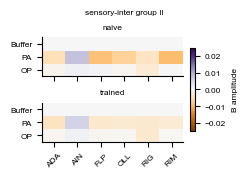

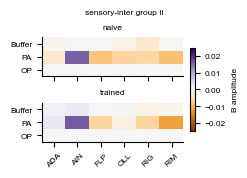

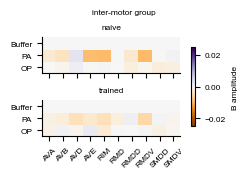

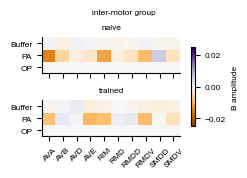

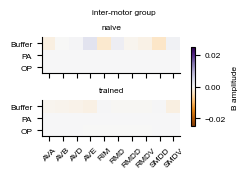

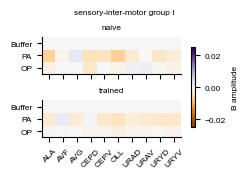

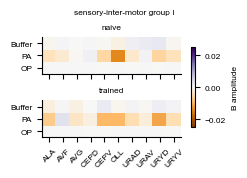

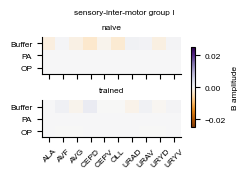

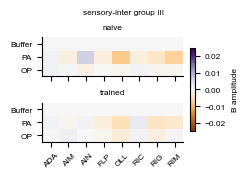

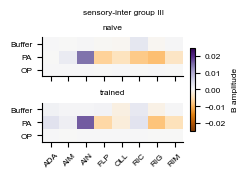

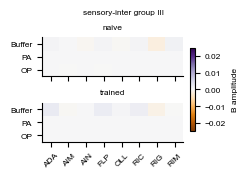

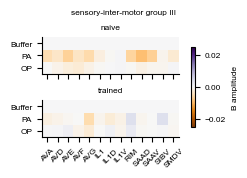

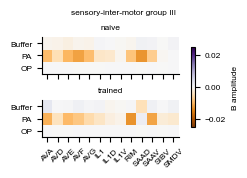

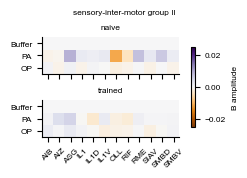

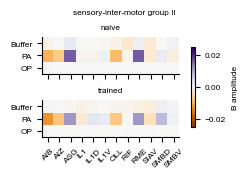

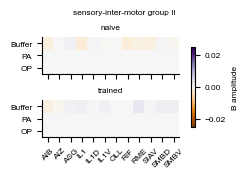

In [50]:
vm = 0.025
dt = 0.2
labs = ['OP', 'PA', 'gacA', 'Buffer']
for gen in fit_systems:
    for prom in fit_systems[gen]:
        for stim in fit_systems[gen][prom]:
            figsize= mm_to_inches((single_column/1.5, max_height/4))
            f, ax = plt.subplots(figsize=figsize, nrows = len(fit_systems[gen][prom][stim]), sharex=True, sharey=True, layout='constrained')
            # vm = max(np.max(np.abs(fit_systems[gen][prom][stim][conds[0]][1])), np.max(np.abs(fit_systems[gen][prom][stim][conds[0]][1])) )
            # ax[0].pcolor(input_tensors[gen][prom][stim], cmap='binary')
            # ax[0].set_yticks(np.arange(4)+0.5, ['OP', 'PA', 'gacA', 'Buffer'], fontsize=font_size_mid)
            # # ax[0].set_xticks(np.arange(input_tensors[gen][prom][stim].shape[1])+0.5, 
            # #                 [str(int(t*dt)) for t in range(0,input_tensors[gen][prom][stim].shape[1],150)], rotation=45, fontsize=font_size_mid)
            # ax[0].tick_params(axis='x', labelsize=font_size_mid)
            # utils.simpleaxis(ax[0])
            # ax[0].set_title('Input (U)', fontsize=font_size_mid)
            for j,cond in enumerate(fit_systems[gen][prom][stim]):
                Blist = fit_systems[gen][prom][stim][cond][1]
                ns = all_neurs_set[prom]
                B  = np.mean(Blist, axis=0) 
                if np.sum(B[:,2]) == 0:
                    inds = [0,1,3]
                    B = B[:, inds]
                else:
                    inds = [0,2,3]
                    B = B[:, inds]
                # for B in Blist:
                # vm = np.max(np.abs(B))
                cbar = ax[j].pcolor(B.T, vmin=-vm, vmax=vm, cmap='PuOr')
                ax[j].set_xticks(np.arange(len(ns))+0.5, ns, rotation=45, fontsize=font_size_mid)
                ax[j].set_yticks(np.arange(3)+0.5, [labs[i] for i in inds], fontsize=font_size_mid)
                utils.simpleaxis(ax[j])
                ax[j].set_title(cond, fontsize=font_size_mid)

                # for i, B in enumerate(Blist):
                #     print(f"Worm {i} ‖B‖_F:", np.linalg.norm(B))
            cbar = f.colorbar(cbar, ax=ax.ravel(), shrink=0.8, orientation='vertical')
            cbar.ax.tick_params(labelsize=font_size_mid)
            cbar.set_label('B amplitude', fontsize=font_size_mid)

            f.suptitle(f'{promoter_names[prom]}', fontsize=font_size_mid)
            plt.savefig(f'figures/B_matrices/{gen}_{prom}_{stim}_B_matrices.svg', dpi=600, transparent=True)
            plt.show()